In [58]:
import pandas as pd
import numpy as np
import timeit

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (20.0, 10.0)
from matplotlib import colors

import scipy.stats

In [59]:
import plot
import calculate

In [60]:
CAREER_LEN = 15

In [61]:
# Publication data
authorPublicationData = pd.read_csv('data/author_publications_2017_asiansAsNone.txt')
author_year_numPub = authorPublicationData.groupby(['author', 'year'])['pub_id'].count()

In [62]:
credible_authors = pd.read_csv('data/authors-scientific-atleast-'+ str(CAREER_LEN) + '-year_extended.csv', encoding='utf-8')

In [63]:
credible_authors = credible_authors.set_index('start_year')

/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


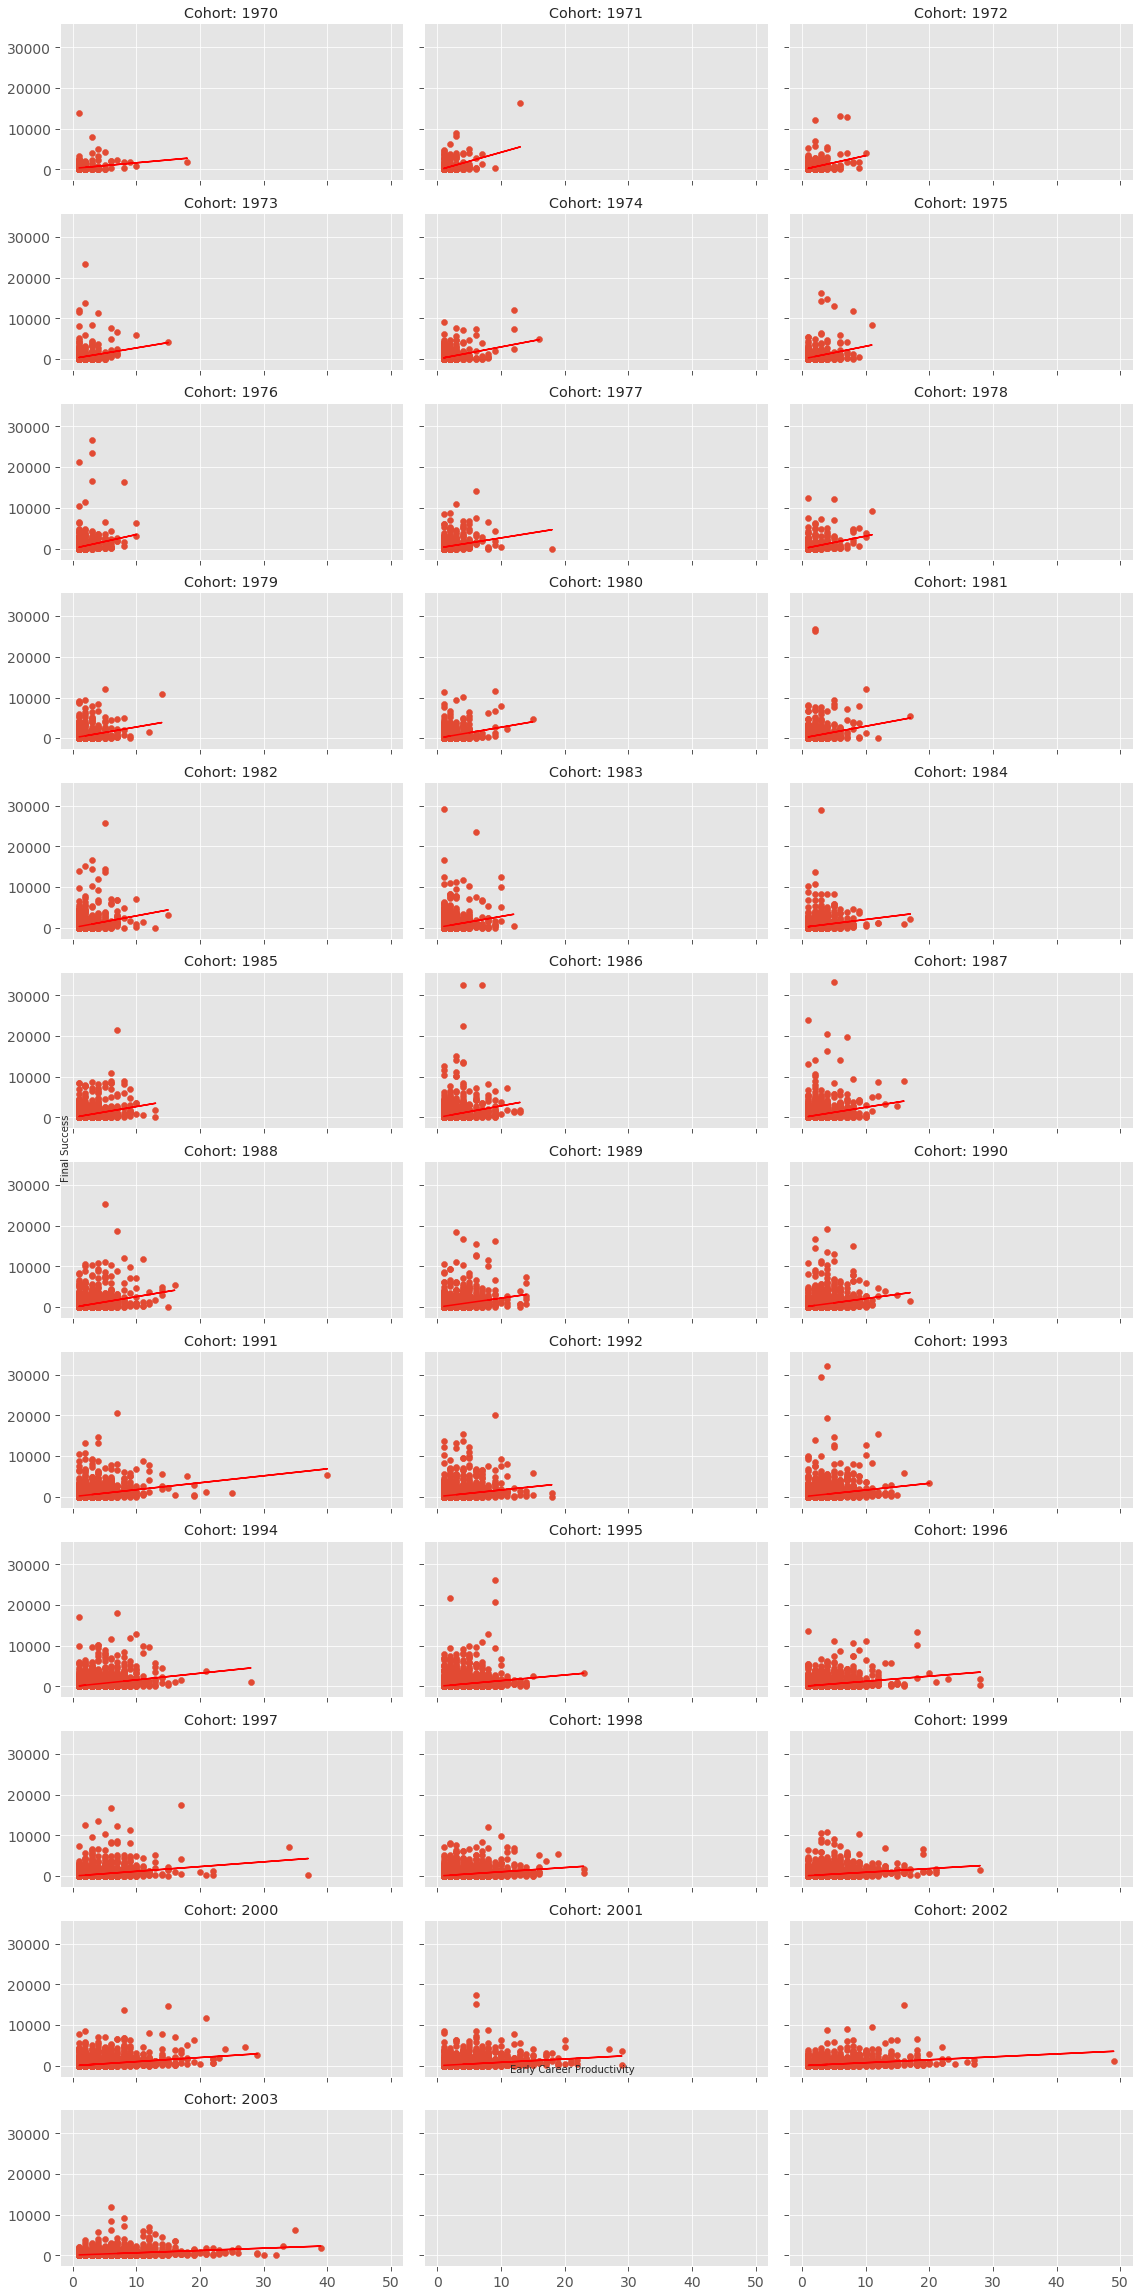

In [64]:
fig, ax = plt.subplots(nrows=12, ncols=3, sharex=True, sharey=True, figsize=(16,32))
for year in range(1970, 2004):
    data = credible_authors.loc[year]
    x = data['early_career_prod']
    y = data['final_citation_count']
    axes = ax[(year-1970)//3,year%1970%3]
    axes.scatter(x, y)
    fit = np.polyfit(x, y, deg=1)
    axes.plot(x, fit[0] * x + fit[1], color='red')
    axes.set_title("Cohort: " + str(year))
    # plt.xlim(0, 50)
    # plt.ylim(0,200)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
#     print("R squared: ", r_value)
    #     print(slope, intercept)
fig.text(0.5, 0.1, 'Early Career Productivity', ha='center', va='center')
fig.text(0.06, 0.5, 'Final Success', ha='center', va='center', rotation='vertical')
plt.show()

In [65]:
credible_authors.reset_index(inplace=True)

In [66]:
authorPublicationData = authorPublicationData.merge(credible_authors, how="inner", on=["author"])

In [67]:
authorPublicationData.shape
#inner

(4206948, 13)

In [68]:
groupByYearData = calculate.groupDataAndCalculateCumulativeValues(authorPublicationData, 1, 'num_pub')

In [69]:
years = groupByYearData['year'].unique()
years = sorted(years)
END_YEAR = 2015
CAREER_LENGTH = 5
cohort_start_years = [y for y in years if y < (END_YEAR - CAREER_LENGTH)]

In [70]:
plot.run_cohort_analysis(groupByYearData, cohort_start_years, CAREER_LENGTH, "num_pub", "Publications")  

   year             author                                pub_id  start_year  \
0  1970    igor aleksander  c9b22ad2-27b2-400b-bae2-9e66eb169f82        1970   
1  1970        david hsiao  b2f04497-4a12-46b0-b227-1274869f5080        1970   
2  1970  stephen r. bourne  9ee2d927-fc06-49bb-bd46-21ef5f39cc38        1970   

   end_year  num_pub  career_length  early_career_prod  early_career_prod_1  \
0      2014       34             45                  1                    1   
1      2014        3             45                  1                    1   
2      2013        4             44                  2                    1   

   early_career_prod_2  early_career_qual  final_citation_count gender  \
0                    1                 16                  85.0      m   
1                    1                 73                  77.0   none   
2                    2                  9                  12.0   none   

   cum_num_pub  
0           34  
1            3  
2            4

ZeroDivisionError: float division by zero